In [2]:
# Cell 1: Setup
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from data.load_data import load_brent_data
from data.clean_data import clean_brent_data
from data.features import engineer_features

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


In [9]:

# Cell 2: Load and Clean
raw_df = load_brent_data('../data/raw/BrentOilPrices.csv')
clean_df = clean_brent_data(raw_df)


INFO:data.load_data:Loading data from ..\data\raw\BrentOilPrices.csv
INFO:data.load_data:Loaded 9011 rows
d:\KAIM\brent_oil_change_point_analysis\notebooks\../src\data\load_data.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df['Date'])
INFO:data.load_data:Validation complete: {'total_rows': 9011, 'missing_dates': np.int64(0), 'missing_prices': np.int64(0), 'duplicate_dates': np.int64(0), 'negative_prices': np.int64(0), 'zero_prices': np.int64(0), 'price_range': {'min': np.float64(9.1), 'max': np.float64(143.95)}, 'date_parseable': True}
INFO:data.clean_data:Parsing dates...
INFO:data.clean_data:Sorting by date...
INFO:data.clean_data:Cleaning complete: 8360 rows



        === BRENT OIL DATA SUMMARY ===
        Total Records: 9,011
        Date Range: 01-Apr-02 to Sep 30, 2022
        Price Range: $9.10 - $143.95
        
        Quality Checks:
        - Missing Dates: 0
        - Missing Prices: 0
        - Duplicate Dates: 0
        - Negative Prices: 0
        - Zero Prices: 0
        


In [10]:
df = engineer_features(clean_df)

print(df.columns.tolist())

INFO:data.features:Calculating returns...
INFO:data.features:Calculating volatility for windows: [7, 30, 90]
INFO:data.features:Adding time features...
INFO:data.features:Adding moving averages: [10, 30, 100, 200]
INFO:data.features:Adding trend features...
INFO:data.features:Created 25 features


['Date', 'Price', 'Log_Price', 'Log_Return', 'Simple_Return', 'Volatility_7d', 'Volatility_30d', 'Volatility_90d', 'Year', 'Month', 'Quarter', 'DayOfYear', 'DayOfWeek', 'IsMonthEnd', 'MA_10', 'Price_to_MA_10', 'MA_30', 'Price_to_MA_30', 'MA_100', 'Price_to_MA_100', 'MA_200', 'Price_to_MA_200', 'Momentum_1d', 'Momentum_5d', 'Momentum_10d', 'Momentum_30d', 'Cumulative_Return']


In [7]:
# Check if dates are actually datetime objects
print("Date column type:", type(df['Date'].iloc[0]))
print("Sample dates:")
print(df['Date'].head())

Date column type: <class 'pandas.Timestamp'>
Sample dates:
0   1987-05-20
1   1987-05-21
2   1987-05-22
3   1987-05-25
4   1987-05-26
Name: Date, dtype: datetime64[us]


In [8]:
print("Columns created:", len(df.columns))
print(df[['Date', 'Price', 'Log_Return', 'Volatility_30d']].head())

Columns created: 27
        Date  Price  Log_Return  Volatility_30d
0 1987-05-20  18.63         NaN             NaN
1 1987-05-21  18.45   -0.009709             NaN
2 1987-05-22  18.55    0.005405             NaN
3 1987-05-25  18.60    0.002692             NaN
4 1987-05-26  18.63    0.001612             NaN


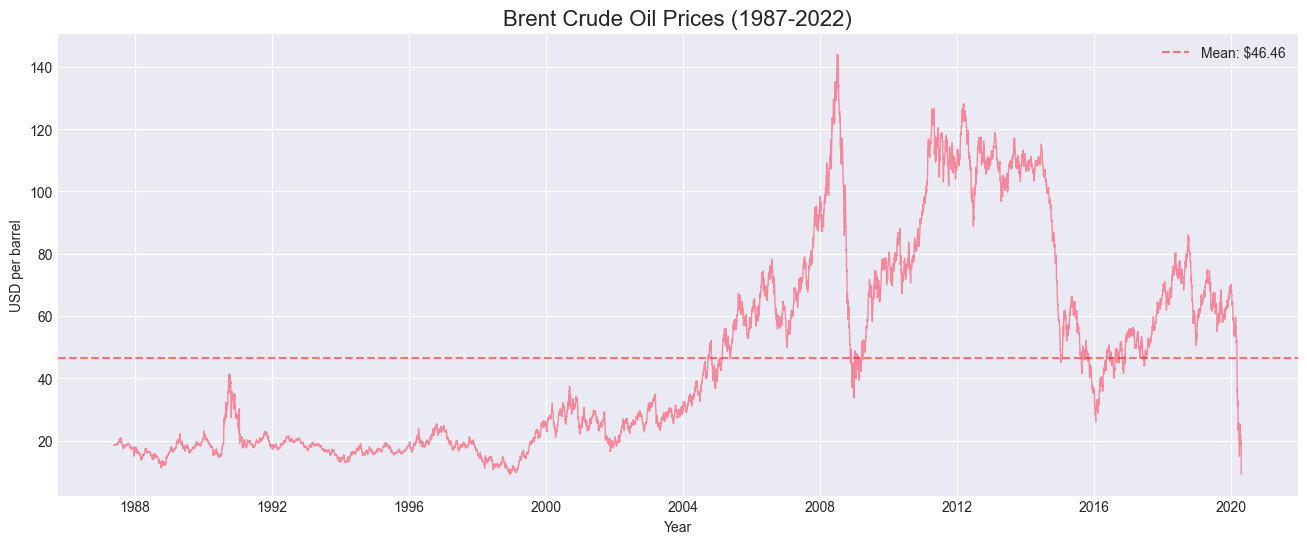

In [11]:

# Cell 4: Full Time Series Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['Date'], df['Price'], linewidth=1, alpha=0.8)
ax.set_title('Brent Crude Oil Prices (1987-2022)', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('USD per barrel')
ax.axhline(y=df['Price'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: ${df["Price"].mean():.2f}')
ax.legend()
plt.savefig('../reports/figures/01_full_series.png', dpi=300)
plt.show()


In [12]:

# Cell 5: Stationarity Test
result = adfuller(df['Log_Return'].dropna())
print(f'ADF Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
if result[1] < 0.05:
    print("✅ Series is stationary")
else:
    print("❌ Series is non-stationary")


ADF Statistic: -12.603089
p-value: 0.000000
✅ Series is stationary


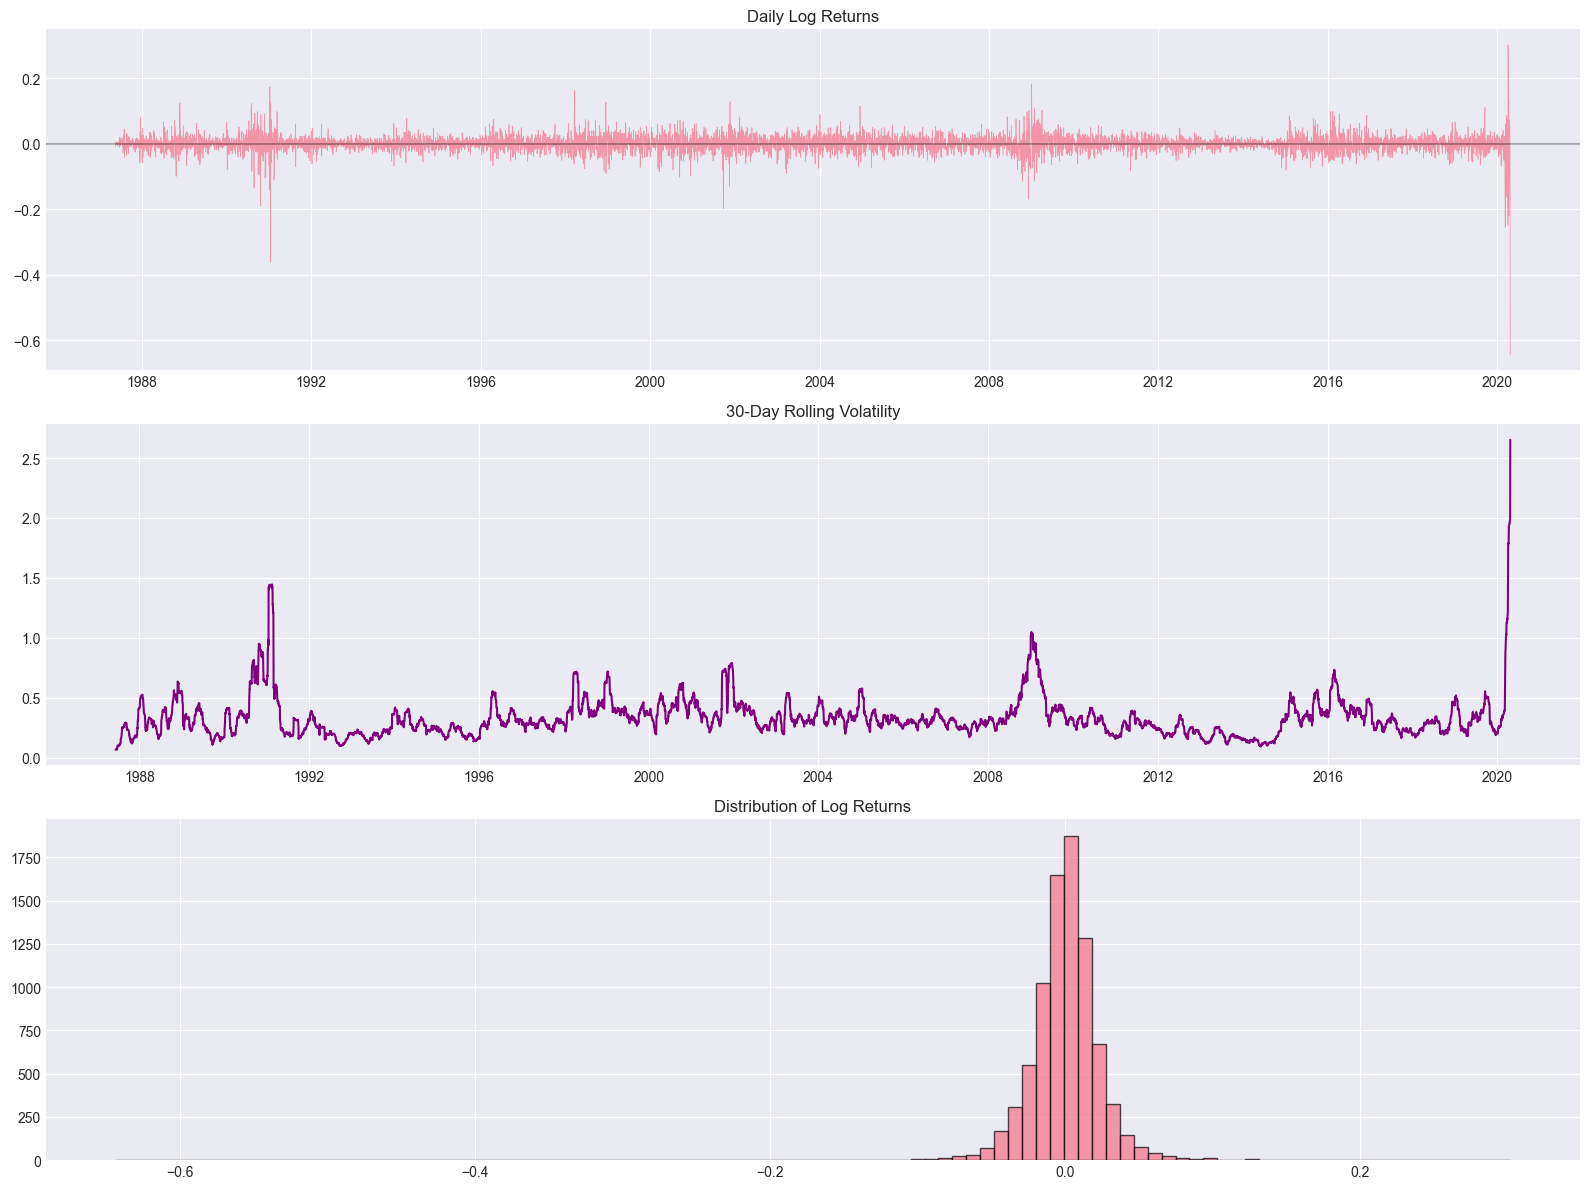

In [13]:

# Cell 6: Returns and Volatility
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
axes[0].plot(df['Date'], df['Log_Return'], alpha=0.7, linewidth=0.5)
axes[0].set_title('Daily Log Returns')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

axes[1].plot(df['Date'], df['Volatility_30d'], color='purple')
axes[1].set_title('30-Day Rolling Volatility')

axes[2].hist(df['Log_Return'].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[2].set_title('Distribution of Log Returns')
plt.tight_layout()
plt.savefig('../reports/figures/02_returns_volatility.png', dpi=300)
plt.show()


In [ ]:

# Cell 7: Save Processed Data
df.to_csv('../data/processed/features_engineered.csv', index=False)
print("Saved engineered features to data/processed/")